In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.constants as const
from ionization import ionization
from scipy.interpolate import interp1d
from scipy import integrate
from scipy.special import dawsn
from scipy.special import gamma
from scipy.interpolate import interp1d
from ionization import adk
from scipy.optimize import curve_fit
plt.style.use('presentation')

c = const.physical_constants['speed of light in vacuum'][0]
me = const.physical_constants['electron mass'][0]
e = const.physical_constants['elementary charge'][0]
hbar = const.physical_constants['Planck constant over 2 pi'][0]
alpha = const.physical_constants['fine-structure constant'][0]

In [2]:
def ionization_plot(atom, I, t, tau, Z, chirp=0):
    IN = np.size(I)
    env = np.zeros(IN)
    for x in range(0, IN):
        Eenv = abs(ionization.gaussian_envelope(I[x], t, tau))
        env[x] = adk.ionization_frac(atom['EI'], Eenv, t, Z, atom['l'], atom['m'], True)
    return env

def BSI_threshold(EI):
    return 4.004e9*EI**4

BSI intensity 3.38E+12 W/cm^2
Keldysh at BSI 3.66


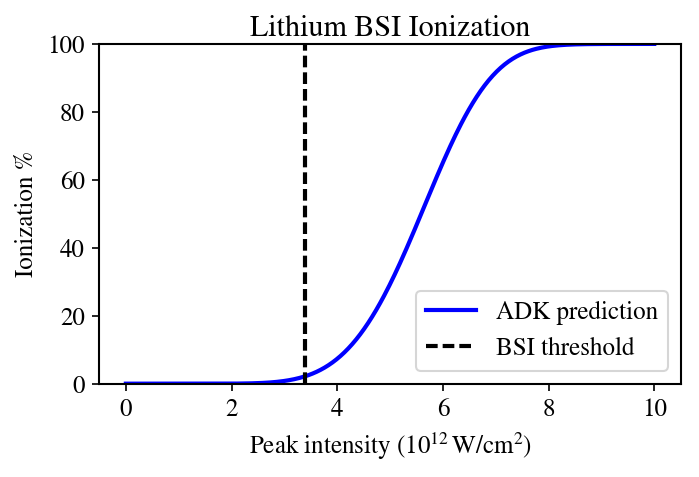

In [3]:
# Ionization rate plots
I = np.linspace(0, 1e-1, 400)
t = np.arange(-200, 200, 1)
tau = 70
atom = ionization.Li

plasma = ionization_plot(atom, I, t, tau, 1)*100
BSI = BSI_threshold(atom['EI'])
print('BSI intensity %0.2E W/cm^2' % BSI)
print('Keldysh at BSI %0.2f' % ionization.keldysh(atom['EI'],BSI/1e14, 0.8))

plt.figure(figsize=(5, 3), dpi=150)
plt.plot(I*100, plasma, 'b-')
plt.plot([BSI*1e-12, BSI*1e-12], [0, 100], 'k--')
plt.ylabel('Ionization %')
plt.xlabel('Peak intensity ($10^{12}\,\mathrm{W/cm}^2$)')
plt.title('Lithium BSI Ionization')
plt.legend(['ADK prediction', 'BSI threshold'])
plt.ylim(0, 100)
plt.show()
# Is lithium even ADK regime? What is the Keldysh parameter? Need PPT?

BSI intensity 2.27E+14 W/cm^2
Keldysh at BSI 0.76


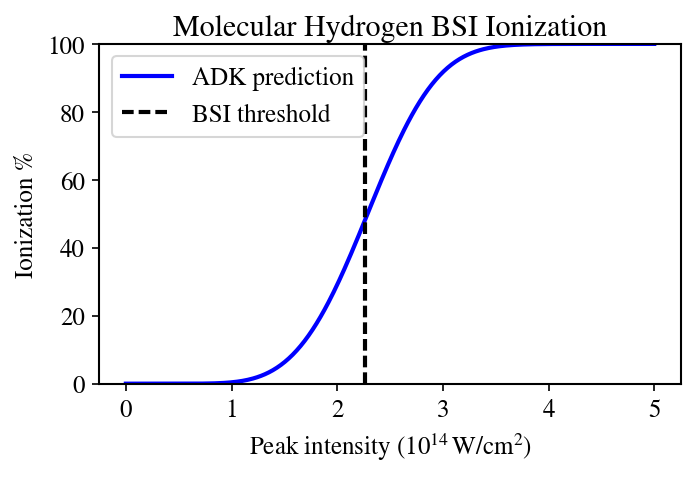

In [4]:
# Ionization rate plots
I = np.linspace(0, 5, 400)
t = np.arange(-200, 200, 1)
tau = 70
atom = ionization.H2

plasma = ionization_plot(atom, I, t, tau, 1)*100
BSI = BSI_threshold(atom['EI'])
print('BSI intensity %0.2E W/cm^2' % BSI)
print('Keldysh at BSI %0.2f' % ionization.keldysh(atom['EI'],BSI/1e14, 0.8))

plt.figure(figsize=(5, 3), dpi=150)
plt.plot(I, plasma, 'b-')
plt.plot([BSI*1e-14, BSI*1e-14], [0, 100], 'k--')
plt.ylabel('Ionization %')
plt.xlabel('Peak intensity ($10^{14}\,\mathrm{W/cm}^2$)')
plt.title('Molecular Hydrogen BSI Ionization')
plt.legend(['ADK prediction', 'BSI threshold'])
plt.ylim(0, 100)
plt.show()

BSI intensity 2.47E+14 W/cm^2
Keldysh at BSI 0.73


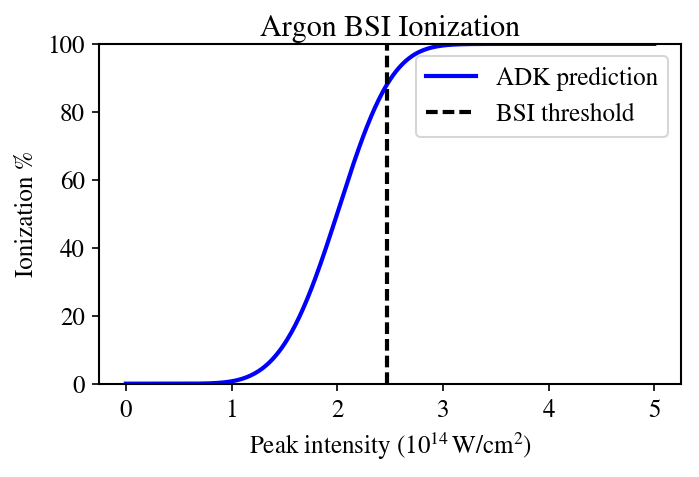

In [5]:
# Ionization rate plots
I = np.linspace(0, 5, 400)
t = np.arange(-200, 200, 1)
tau = 70
atom = ionization.Ar

plasma = ionization_plot(atom, I, t, tau, 1)*100
BSI = BSI_threshold(atom['EI'])
print('BSI intensity %0.2E W/cm^2' % BSI)
print('Keldysh at BSI %0.2f' % ionization.keldysh(atom['EI'],BSI/1e14, 0.8))

plt.figure(figsize=(5, 3), dpi=150)
plt.plot(I, plasma, 'b-')
plt.plot([BSI*1e-14, BSI*1e-14], [0, 100], 'k--')
plt.ylabel('Ionization %')
plt.xlabel('Peak intensity ($10^{14}\,\mathrm{W/cm}^2$)')
plt.title('Argon BSI Ionization')
plt.legend(['ADK prediction', 'BSI threshold'])
plt.ylim(0, 100)
plt.show()

BSI intensity 1.46E+15 W/cm^2
Keldysh at BSI 0.38


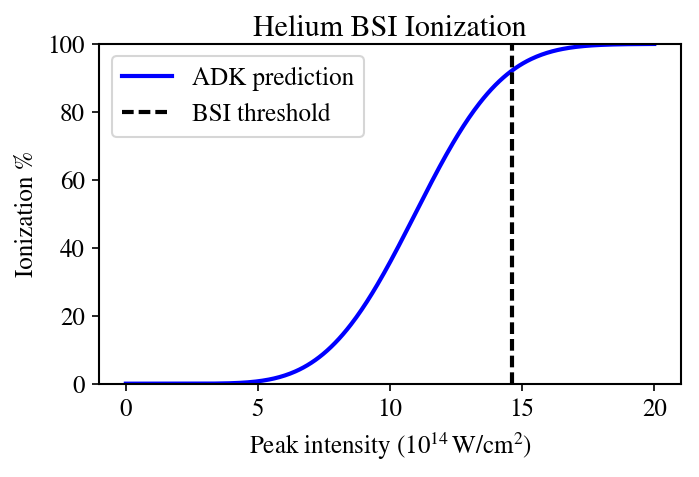

In [6]:
# Ionization rate plots
I = np.linspace(0, 20, 400)
t = np.arange(-200, 200, 1)
tau = 70
atom = ionization.He

plasma = ionization_plot(atom, I, t, tau, 1)*100
BSI = BSI_threshold(atom['EI'])
print('BSI intensity %0.2E W/cm^2' % BSI)
print('Keldysh at BSI %0.2f' % ionization.keldysh(atom['EI'],BSI/1e14, 0.8))

plt.figure(figsize=(5, 3), dpi=150)
plt.plot(I, plasma, 'b-')
plt.plot([BSI*1e-14, BSI*1e-14], [0, 100], 'k--')
plt.ylabel('Ionization %')
plt.xlabel('Peak intensity ($10^{14}\,\mathrm{W/cm}^2$)')
plt.title('Helium BSI Ionization')
plt.legend(['ADK prediction', 'BSI threshold'])
plt.ylim(0, 100)
plt.show()

In [7]:
# PPT model for lithium
from scipy.special import dawsn
from scipy.special import gamma
from ionization import adk

c = const.physical_constants['speed of light in vacuum'][0]
me = const.physical_constants['electron mass'][0]
e = const.physical_constants['elementary charge'][0]
hbar = const.physical_constants['Planck constant over 2 pi'][0]
alpha = const.physical_constants['fine-structure constant'][0]

atom = ionization.Li

xi = atom['EI'] # eV - ionization energy
Z = atom['Z']        # atomic residue
l = atom['l']        # orbital angular momentum quantum number
lam = 0.8    # um - laser wavelength

In [8]:
# First, calculate all the parameters that depend only on the species being ionized
w = 2*np.pi*c / (lam * 1e-6)
E0 = (2*xi)**1.5 * np.sqrt(me*e) / hbar
n = alpha*c*Z*np.sqrt(me/(2*e*xi))
f = 2*l + 1
C2 = 4**n / (n*gamma(2*n))

print('omega: %.3e' % w)
print('f    : %.2f THz' % (w/1e12/2/np.pi,))
print('E0   : %.2f GV/m' % (E0/1e9))
print('n*   : %.4f' % n)
print('Cnl2 : %.4f' % C2)
print('hw   : %.4f eV' % (hbar*w/e))

omega: 2.355e+15
f    : 374.74 THz
E0   : 128.28 GV/m
n*   : 1.5885
Cnl2 : 2.4031
hw   : 1.5498 eV


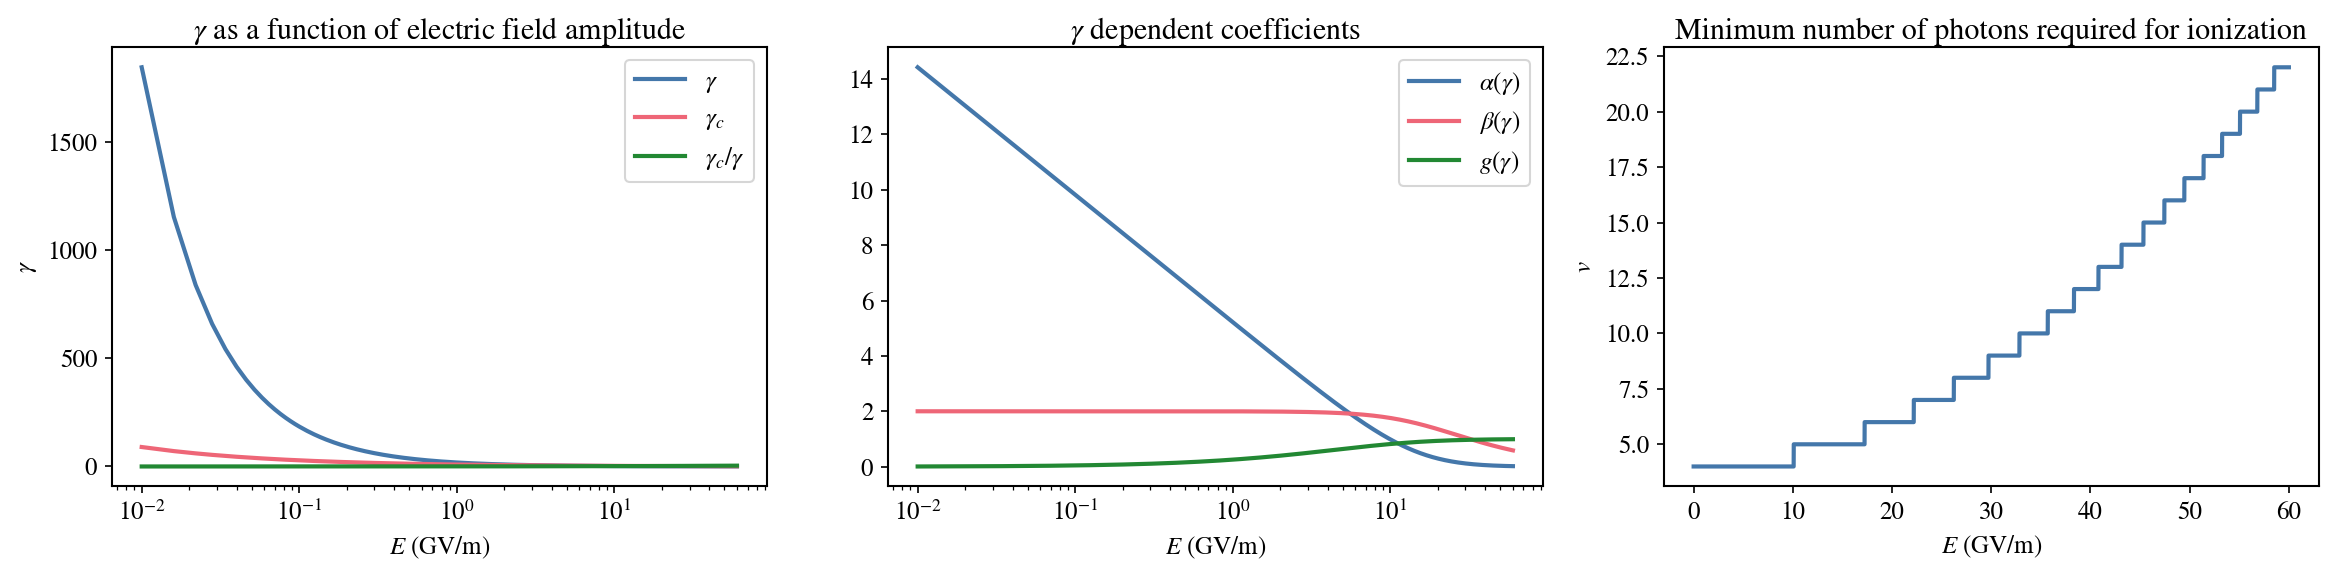

In [9]:
# Next, calculate gamma and functions of gamma for E from 1GV/m to 100GV/m
E = np.linspace(1e7, 60e9, 10000)
gamma  = (w/E) * np.sqrt(2*me*xi/e)
gammac = np.sqrt(E0/(n*E))
alpha  = 2*(np.arcsinh(gamma) - gamma/np.sqrt(1+gamma**2))
beta   = 2*gamma / np.sqrt(1+gamma**2)
g      = 3/(2*gamma) * ((1+1/(2*gamma**2))*np.arcsinh(gamma) - np.sqrt(1+gamma**2)/(2*gamma))
v      = e*xi/(hbar*w) * (1+1/(2*gamma**2))

plt.figure(figsize=(16,4), dpi=150)
gs = gridspec.GridSpec(1, 3)
plt.subplot(gs[0, 0])
plt.plot(E/1e9, gamma, E/1e9, gammac, E/1e9, gammac/gamma)
plt.title(r'$\gamma$ as a function of electric field amplitude')
plt.xlabel(r'$E$ (GV/m)')
plt.ylabel(r'$\gamma$')
plt.legend([r'$\gamma$', r'$\gamma_c$', r'$\gamma_c/\gamma$'])
plt.xscale('log')

plt.subplot(gs[0, 1])
plt.plot(E/1e9, alpha, E/1e9, beta, E/1e9, g)
plt.title(r'$\gamma$ dependent coefficients')
plt.xlabel(r'$E$ (GV/m)')
plt.legend([r'$\alpha(\gamma)$', r'$\beta(\gamma)$', r'$g(\gamma)$'])
plt.xscale('log')

plt.subplot(gs[0, 2])
plt.plot(E/1e9, v - (v % 1) + 1)
plt.title(r'Minimum number of photons required for ionization')
plt.xlabel(r'$E$ (GV/m)')
plt.ylabel(r'$v$')
plt.tight_layout()
plt.show()

/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in sqrt


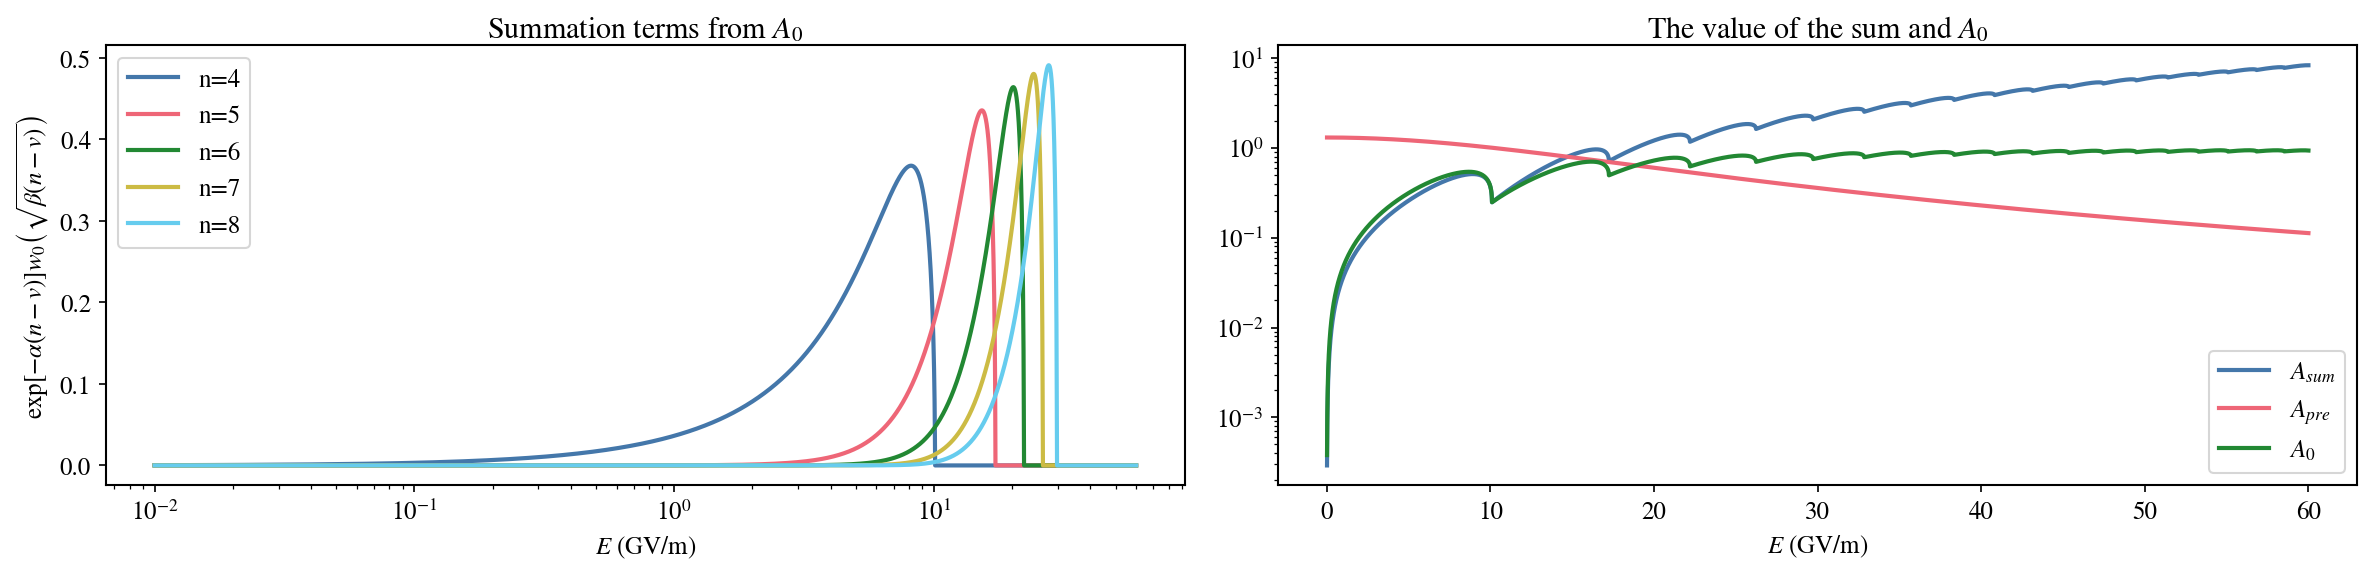

In [10]:
# Next, we calculate the first couple terms of the infinite series for MPI
Apre = 4*gamma**2/(np.sqrt(3*np.pi)*(1+gamma**2))
def An(n):
    ret =  np.exp(-alpha*(n-v))*dawsn(np.sqrt(beta*(n-v)))
    ret[n < v] = 0.0
    return ret
Asum = An(4)
for i in range(180):
    Asum += An(5+i)

plt.figure(figsize=(16,4), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0, 0])
plt.plot(E/1e9, An(4), E/1e9, An(5), E/1e9, An(6), E/1e9, An(7), E/1e9, An(8))
plt.title(r'Summation terms from $A_0$')
plt.xlabel(r'$E$ (GV/m)')
plt.ylabel(r'$\exp[-\alpha(n-v)]w_0\left(\sqrt{\beta(n-v)}\right)$')
plt.legend(['n=4', 'n=5', 'n=6', 'n=7', 'n=8'])
plt.xscale('log')

plt.subplot(gs[0, 1])
plt.plot(E/1e9, Asum, E/1e9, Apre, E/1e9, Apre*Asum)
plt.title(r'The value of the sum and $A_0$')
plt.xlabel(r'$E$ (GV/m)')
plt.legend([r'$A_{sum}$', r'$A_{pre}$', r'$A_0$'])
plt.yscale('log')

plt.tight_layout()
plt.show()

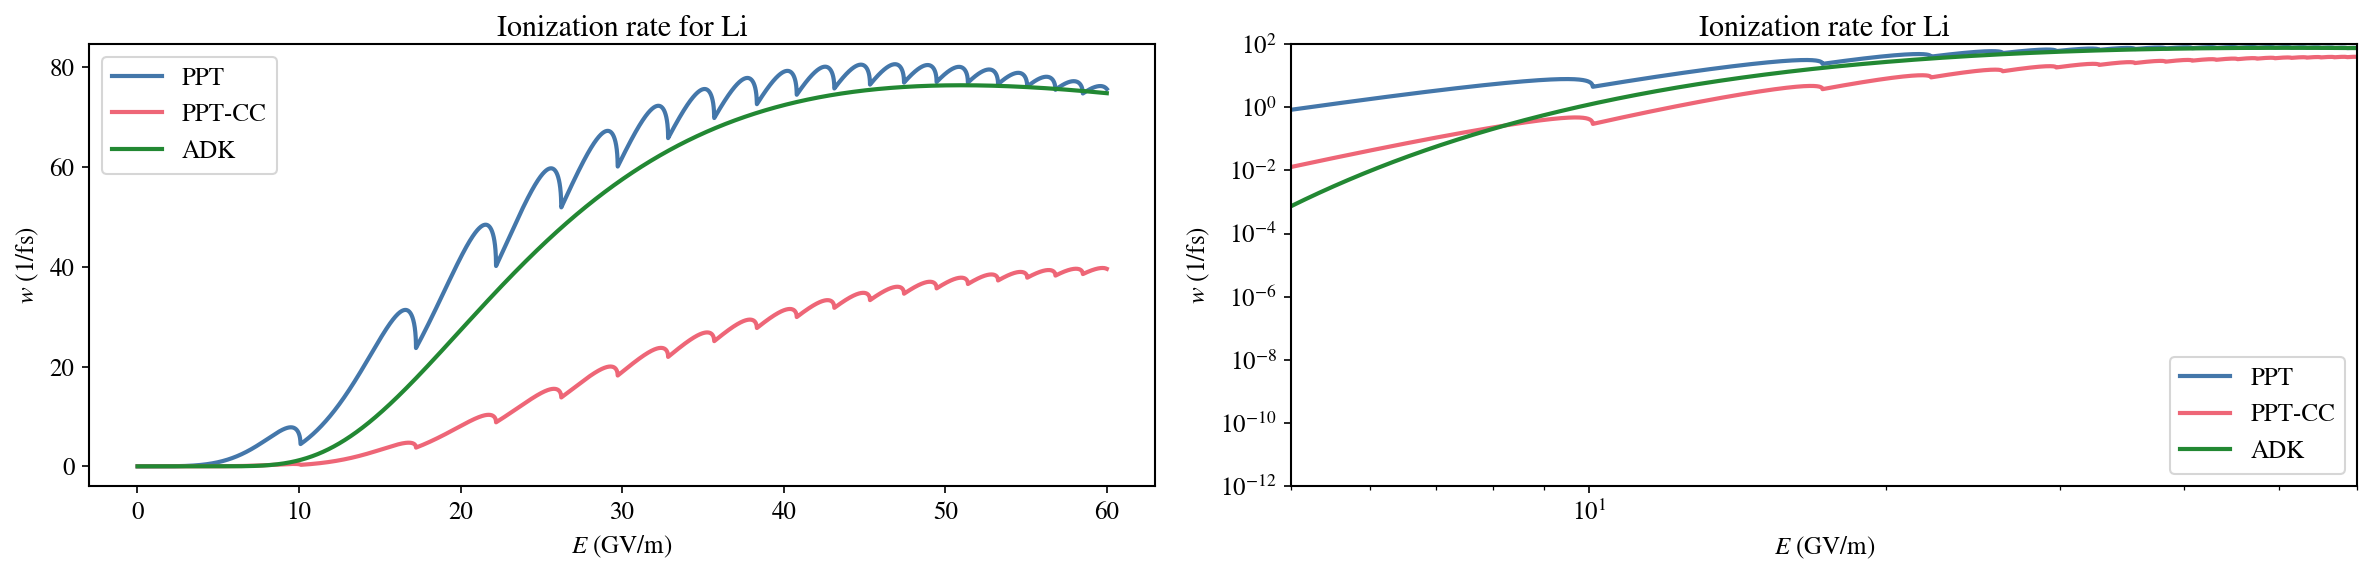

In [11]:
# Put it all together to find the ionization rate
ratePPT = C2*e/hbar*np.sqrt(6/np.pi)*(2*l+1)*xi \
          *(2*E0/E)**(2*n-1.5)*(1+gamma**2)**0.75 \
          *Apre*Asum*np.exp(-2*E0*g/(3*E))/1e15
        
rateADK = C2*e/hbar*np.sqrt(6/np.pi)*(2*l+1)*xi \
          *(2*E0/E)**(2*n-1.5)*np.exp(-2*E0/(3*E))/1e15

# This is jus a sanity check but it is indeed the same as rateADK
rateADK2 = adk.rate_linear(xi, E/1e9, 1, 0, 0)

ratePPTCC = ratePPT * (1 + 2*gamma/np.exp(1))**(-2*n)

plt.figure(figsize=(16,4), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0, 0])
plt.plot(E/1e9, ratePPT, E/1e9, ratePPTCC, E/1e9, rateADK)
plt.title(r'Ionization rate for Li')
plt.xlabel(r'$E$ (GV/m)')
plt.ylabel(r'$w$ (1/fs)')
plt.legend(['PPT', 'PPT-CC', 'ADK'])

plt.subplot(gs[0, 1])
plt.plot(E/1e9, ratePPT, E/1e9, ratePPTCC, E/1e9, rateADK)
plt.title(r'Ionization rate for Li')
plt.xlabel(r'$E$ (GV/m)')
plt.ylabel(r'$w$ (1/fs)')
plt.legend(['PPT', 'PPT-CC', 'ADK'])
plt.xscale('log')
plt.yscale('log')
plt.xlim([5, 60])
plt.ylim([1e-12, 100])

plt.tight_layout()
plt.show()

In [12]:
np.save('E.npy', E/1e9)
np.save('ratePPT-CC.npy', ratePPTCC)

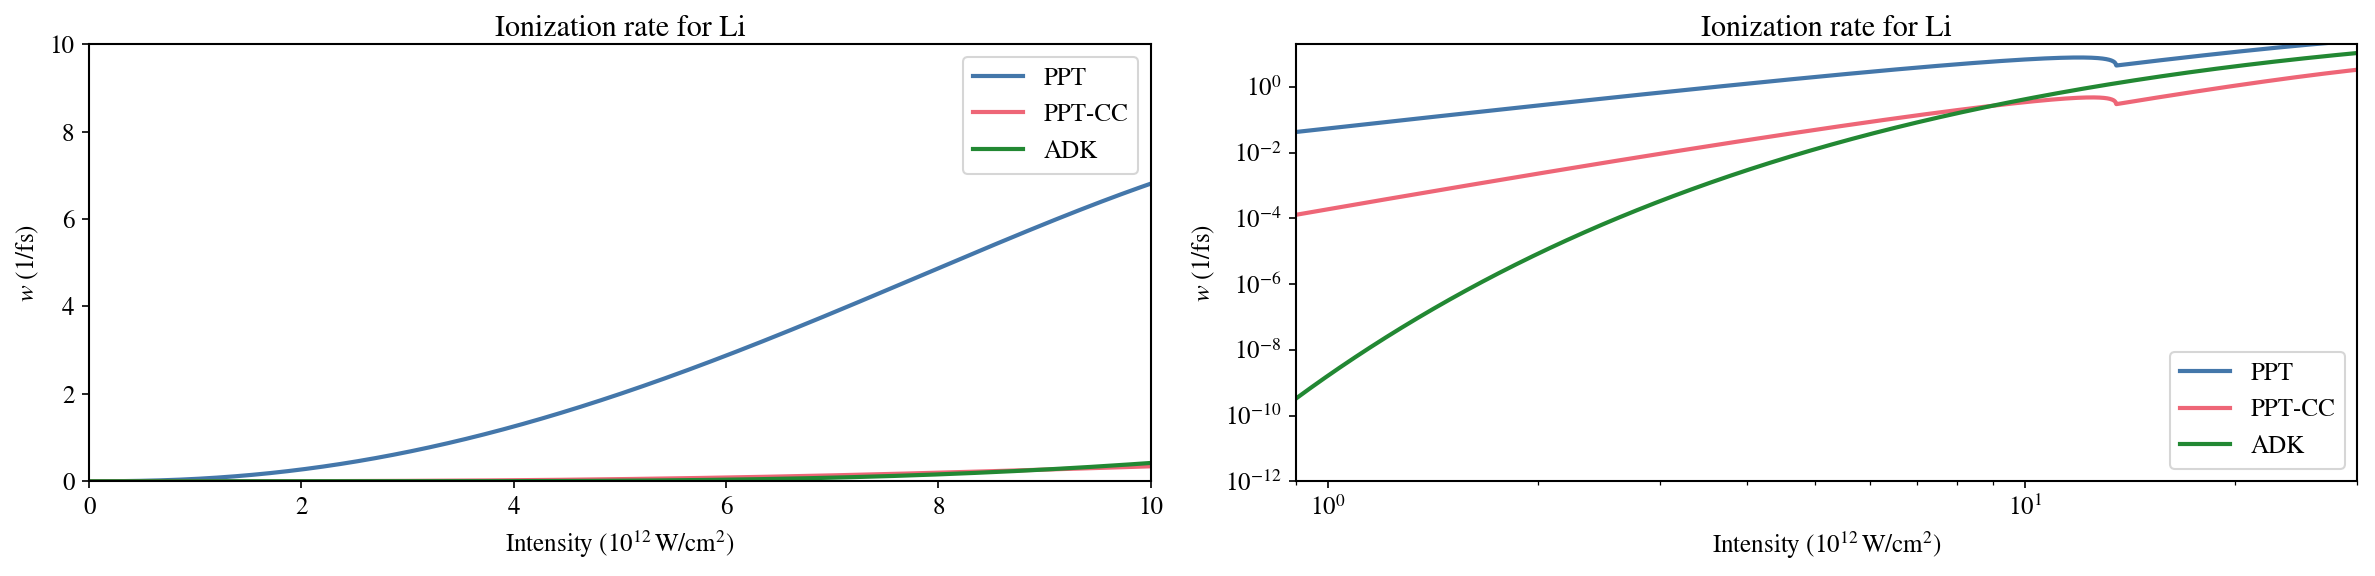

In [13]:
plt.figure(figsize=(16,4), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0, 0])
plt.plot(ionization.intensity_from_field(E/1e9)*100, ratePPT, ionization.intensity_from_field(E/1e9)*100,
         ratePPTCC, ionization.intensity_from_field(E/1e9)*100, rateADK)
plt.title(r'Ionization rate for Li')
plt.xlabel(r'Intensity ($10^{12}\,\mathrm{W/cm}^2$)')
plt.ylabel(r'$w$ (1/fs)')
plt.legend(['PPT', 'PPT-CC', 'ADK'])
plt.xlim(0, 10)
plt.ylim(0, 10)

plt.subplot(gs[0, 1])
plt.plot(ionization.intensity_from_field(E/1e9)*100, ratePPT, ionization.intensity_from_field(E/1e9)*100,
         ratePPTCC, ionization.intensity_from_field(E/1e9)*100, rateADK)
plt.title(r'Ionization rate for Li')
plt.xlabel(r'Intensity ($10^{12}\,\mathrm{W/cm}^2$)')
plt.ylabel(r'$w$ (1/fs)')
plt.legend(['PPT', 'PPT-CC', 'ADK'])
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.9, 30])
plt.ylim([1e-12, 20])

plt.tight_layout()
plt.show()

In [14]:
ionization.field_from_intensity(3e-1)

15.034546025470805

In [15]:
w_ppt = interp1d(E/1e9, ratePPT, fill_value=0., bounds_error=False)
w_pptcc = interp1d(E/1e9, ratePPTCC, fill_value=0., bounds_error=False)

BSI intensity 3.38E+12 W/cm^2
Keldysh at BSI 3.66


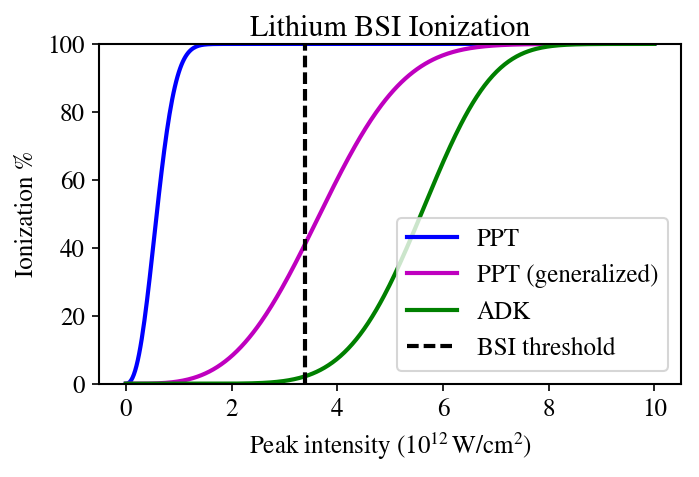

In [16]:
I = np.linspace(0, 10e-2, 400)
t = np.arange(-200, 200, 1)
tau = 70
atom = ionization.Li
IN = np.size(I)
env = np.zeros(IN)
for x in range(0, IN):
    Eenv = abs(ionization.gaussian_envelope(I[x], t, tau))
    rate = w_ppt(Eenv)
    env[x] = 1 - np.exp(-integrate.simps(rate, t))

plasma = env*100

for x in range(0, IN):
    Eenv = abs(ionization.gaussian_envelope(I[x], t, tau))
    rate = w_pptcc(Eenv)
    env[x] = 1 - np.exp(-integrate.simps(rate, t))

plasma2 = env*100
BSI = BSI_threshold(atom['EI'])
print('BSI intensity %0.2E W/cm^2' % BSI)
print('Keldysh at BSI %0.2f' % ionization.keldysh(atom['EI'],BSI/1e14, 0.8))
plasma3 = ionization_plot(atom, I, t, tau, 1)*100

plt.figure(figsize=(5, 3), dpi=150)
plt.plot(I*100, plasma, 'b-')
plt.plot(I*100, plasma2, 'm-')
plt.plot(I*100, plasma3, 'g-')
plt.plot([BSI*1e-12, BSI*1e-12], [0, 100], 'k--')
plt.ylabel('Ionization %')
plt.xlabel('Peak intensity ($10^{12}\,\mathrm{W/cm}^2$)')
plt.title('Lithium BSI Ionization')
plt.legend(['PPT', 'PPT (generalized)', 'ADK', 'BSI threshold'])
plt.ylim(0, 100)
plt.show()

In [17]:
# Extract the ionization rate from the TDSE calculations
t = np.load('time.npy')
p_x0_z0 = np.load('x=0um_z=0cm.npy')
p_x0_z50 = np.load('x=0um_z=50cm.npy')
p_x78_z50 = np.load('x=78um_z=50cm.npy')
t_pulse = np.load('t.npy')
e_x0_z0 = np.load('x=0um_z=0cm_InitialGaussian.npy')
e_x0_z50 = np.load('x=0um_z=50cm_pulseShape.npy')
e_x78_z50 = np.load('x=78um_z=50cm_pulseShape.npy')

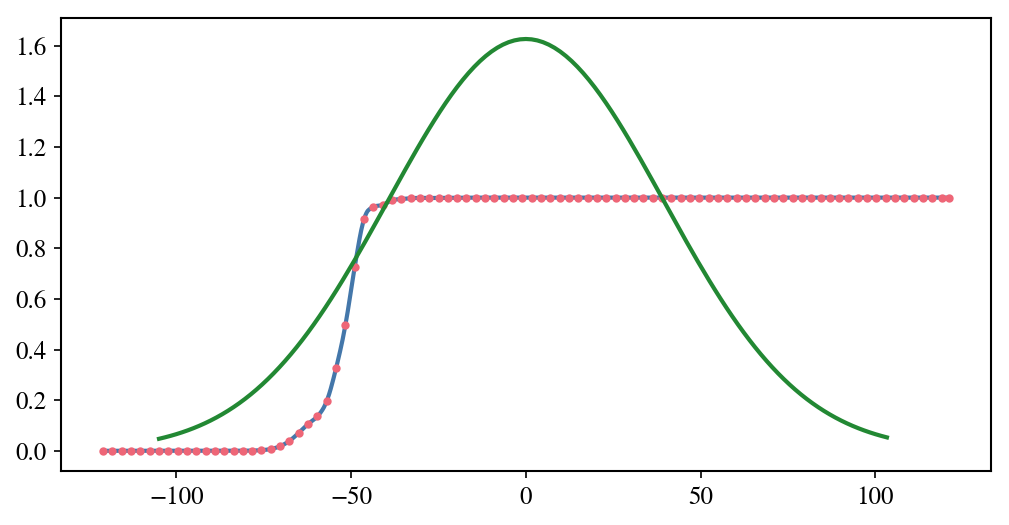

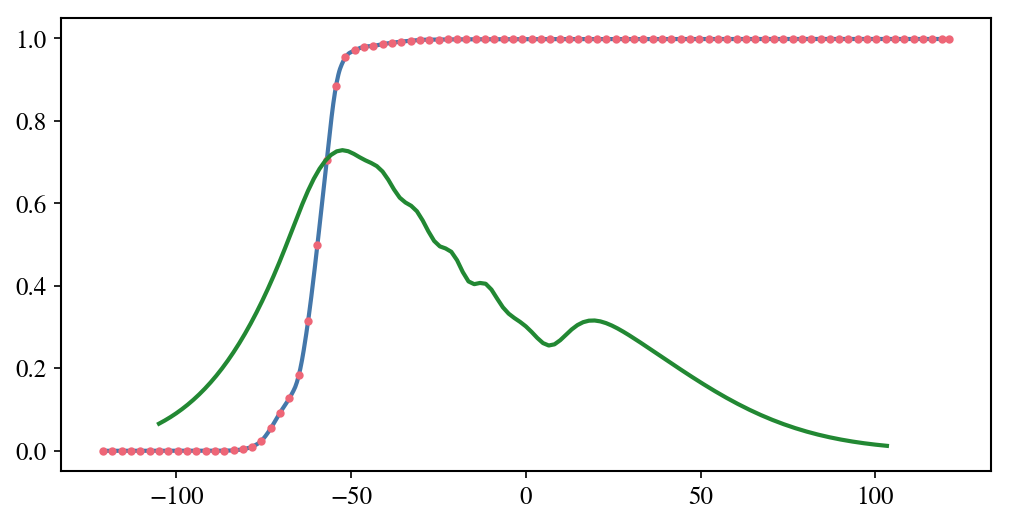

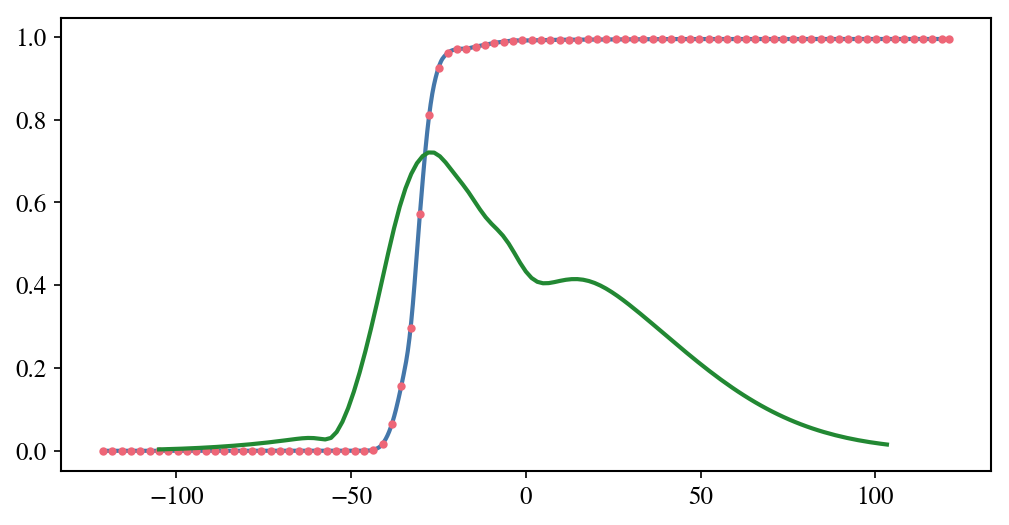

In [18]:
kind = 'quadratic'
p_x0_z0_f = interp1d(t, p_x0_z0, kind=kind)
p_x0_z50_f = interp1d(t, p_x0_z50, kind=kind)
p_x78_z50_f = interp1d(t, p_x78_z50, kind=kind)
kind = 'cubic'
e_x0_z0_f = interp1d(t_pulse, e_x0_z0, kind=kind)
e_x0_z50_f = interp1d(t_pulse, e_x0_z50, kind=kind)
e_x78_z50_f = interp1d(t_pulse, e_x78_z50, kind=kind)

t_plot = np.linspace(t[0], t[-1], 1000)
plt.figure(figsize=(8, 4), dpi=150)
plt.plot(t_plot, p_x0_z0_f(t_plot))
plt.plot(t, p_x0_z0, '.')
plt.plot(t_pulse, e_x0_z0/10)
plt.show()
plt.figure(figsize=(8, 4), dpi=150)
plt.plot(t_plot, p_x0_z50_f(t_plot))
plt.plot(t, p_x0_z50, '.')
plt.plot(t_pulse, e_x0_z50/10)
plt.show()
plt.figure(figsize=(8, 4), dpi=150)
plt.plot(t_plot, p_x78_z50_f(t_plot))
plt.plot(t, p_x78_z50, '.')
plt.plot(t_pulse, e_x78_z50/10)
plt.show()

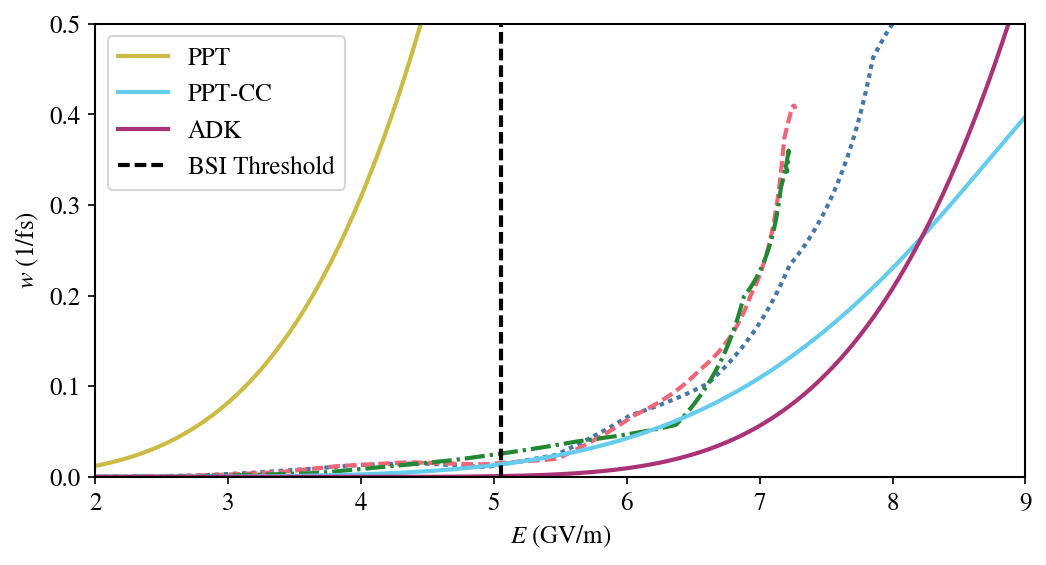

In [19]:
t_rate, dt = np.linspace(-100, 100, 10000, retstep=True)
p0_x0_z0 = 1 - p_x0_z0_f(t_rate)
w_x0_z0 = -np.gradient(p0_x0_z0, dt)/p0_x0_z0
p0_x0_z50 = 1 - p_x0_z50_f(t_rate)
w_x0_z50 = -np.gradient(p0_x0_z50, dt)/p0_x0_z50
p0_x78_z50 = 1 - p_x78_z50_f(t_rate)
w_x78_z50 = -np.gradient(p0_x78_z50, dt)/p0_x78_z50

plt.figure(figsize=(8, 4), dpi=150)
sel = np.logical_and(p0_x0_z0 < 1.0, p0_x0_z0 > 0.1)
plt.plot(e_x0_z0_f(t_rate)[sel], w_x0_z0[sel], ':')
sel = np.logical_and(p0_x0_z50 < 1.0, p0_x0_z50 > 0.1)
plt.plot(e_x0_z50_f(t_rate)[sel], w_x0_z50[sel], '--')
sel = np.logical_and(p0_x78_z50 < 1.0, p0_x78_z50 > 0.1)
plt.plot(e_x78_z50_f(t_rate)[sel], w_x78_z50[sel], '-.')

plt.plot(E/1e9, ratePPT, label='PPT')
plt.plot(E/1e9, ratePPTCC, label='PPT-CC')
plt.plot(E/1e9, rateADK, label='ADK')
atom = ionization.Li
BSI = BSI_threshold(atom['EI'])
BSI = ionization.field_from_intensity(BSI*1e-14)
plt.plot([BSI, BSI], [0, 10], 'k--', label='BSI Threshold')
plt.legend()
plt.xlabel(r'$E$ (GV/m)')
plt.ylabel(r'$w$ (1/fs)')
plt.xlim(2, 9)
plt.ylim(1e-4, 0.5)
plt.show()

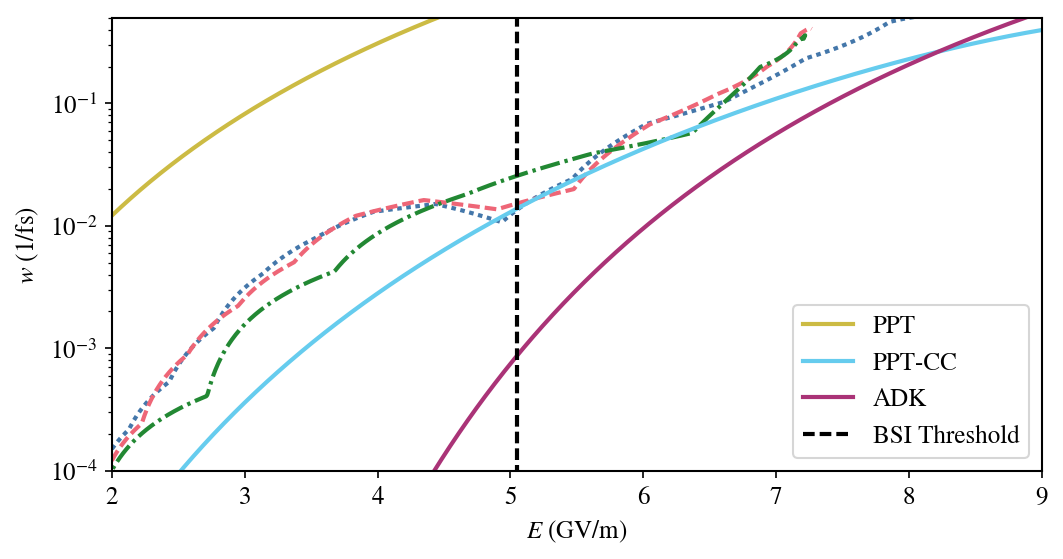

In [20]:
plt.figure(figsize=(8, 4), dpi=150)
sel = np.logical_and(p0_x0_z0 < 1.0, p0_x0_z0 > 0.1)
plt.plot(e_x0_z0_f(t_rate)[sel], w_x0_z0[sel], ':')
sel = np.logical_and(p0_x0_z50 < 1.0, p0_x0_z50 > 0.1)
plt.plot(e_x0_z50_f(t_rate)[sel], w_x0_z50[sel], '--')
sel = np.logical_and(p0_x78_z50 < 1.0, p0_x78_z50 > 0.1)
plt.plot(e_x78_z50_f(t_rate)[sel], w_x78_z50[sel], '-.')

plt.plot(E/1e9, ratePPT, label='PPT')
plt.plot(E/1e9, ratePPTCC, label='PPT-CC')
plt.plot(E/1e9, rateADK, label='ADK')
atom = ionization.Li
BSI = BSI_threshold(atom['EI'])
BSI = ionization.field_from_intensity(BSI*1e-14)
plt.plot([BSI, BSI], [0, 10], 'k--', label='BSI Threshold')
plt.legend()
plt.xlabel(r'$E$ (GV/m)')
plt.ylabel(r'$w$ (1/fs)')
plt.yscale('log')
plt.xlim(2, 9)
plt.ylim(1e-4, 0.5)
plt.show()

In [21]:
# Simple exponential fit in the region we are interested in
sel = np.logical_and(p0_x0_z0 < 0.99, p0_x0_z0 > 0.1)
x1 = e_x0_z0_f(t_rate)[sel]
y1 = w_x0_z0[sel]
sel = np.logical_and(p0_x0_z50 < 0.99, p0_x0_z50 > 0.1)
x2 = e_x0_z50_f(t_rate)[sel]
y2 = w_x0_z50[sel]
sel = np.logical_and(p0_x78_z50 < 0.99, p0_x78_z50 > 0.1)
x3 = e_x78_z50_f(t_rate)[sel]
y3 = w_x78_z50[sel]
xdata = np.concatenate((x1, x2, x3))
ydata = np.log(np.concatenate((y1, y2, y3)))

func = lambda x, a, b: np.log(a*x**b)
popt, pcov = curve_fit(func, xdata, ydata, p0=(1.1, 8.88))
print(popt)

[8.11577991e-06 5.10149119e+00]


/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in log


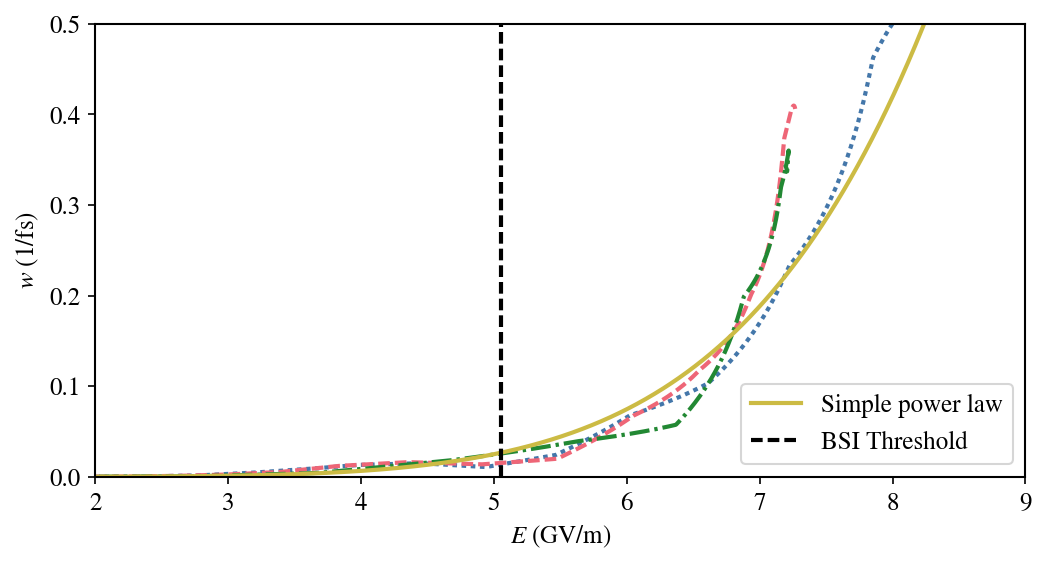

In [22]:
plt.figure(figsize=(8, 4), dpi=150)
sel = np.logical_and(p0_x0_z0 < 1.0, p0_x0_z0 > 0.1)
plt.plot(e_x0_z0_f(t_rate)[sel], w_x0_z0[sel], ':')
sel = np.logical_and(p0_x0_z50 < 1.0, p0_x0_z50 > 0.1)
plt.plot(e_x0_z50_f(t_rate)[sel], w_x0_z50[sel], '--')
sel = np.logical_and(p0_x78_z50 < 1.0, p0_x78_z50 > 0.1)
plt.plot(e_x78_z50_f(t_rate)[sel], w_x78_z50[sel], '-.')

a = 1.6e-6
b = 6
f = lambda x: a*x**b
plt.plot(E/1e9, f(E/1e9), label='Simple power law')
atom = ionization.Li
BSI = BSI_threshold(atom['EI'])
BSI = ionization.field_from_intensity(BSI*1e-14)
plt.plot([BSI, BSI], [0, 10], 'k--', label='BSI Threshold')
plt.legend()
plt.xlabel(r'$E$ (GV/m)')
plt.ylabel(r'$w$ (1/fs)')
plt.xlim(2, 9)
plt.ylim(0, 0.5)
plt.show()

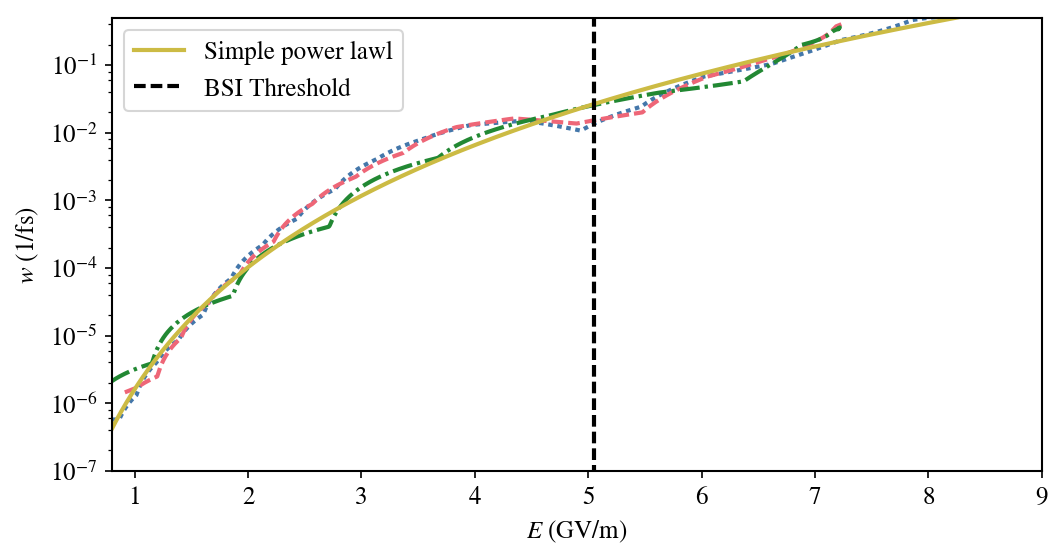

In [23]:
plt.figure(figsize=(8, 4), dpi=150)
sel = np.logical_and(p0_x0_z0 < 1.0, p0_x0_z0 > 0.1)
plt.plot(e_x0_z0_f(t_rate)[sel], w_x0_z0[sel], ':')
sel = np.logical_and(p0_x0_z50 < 1.0, p0_x0_z50 > 0.1)
plt.plot(e_x0_z50_f(t_rate)[sel], w_x0_z50[sel], '--')
sel = np.logical_and(p0_x78_z50 < 1.0, p0_x78_z50 > 0.1)
plt.plot(e_x78_z50_f(t_rate)[sel], w_x78_z50[sel], '-.')

plt.plot(E/1e9, f(E/1e9), label='Simple power lawl')
atom = ionization.Li
BSI = BSI_threshold(atom['EI'])
BSI = ionization.field_from_intensity(BSI*1e-14)
plt.plot([BSI, BSI], [0, 10], 'k--', label='BSI Threshold')
plt.legend()
plt.xlabel(r'$E$ (GV/m)')
plt.ylabel(r'$w$ (1/fs)')
plt.yscale('log')
plt.xlim(0.8, 9)
plt.ylim(1e-7, 0.5)
plt.show()

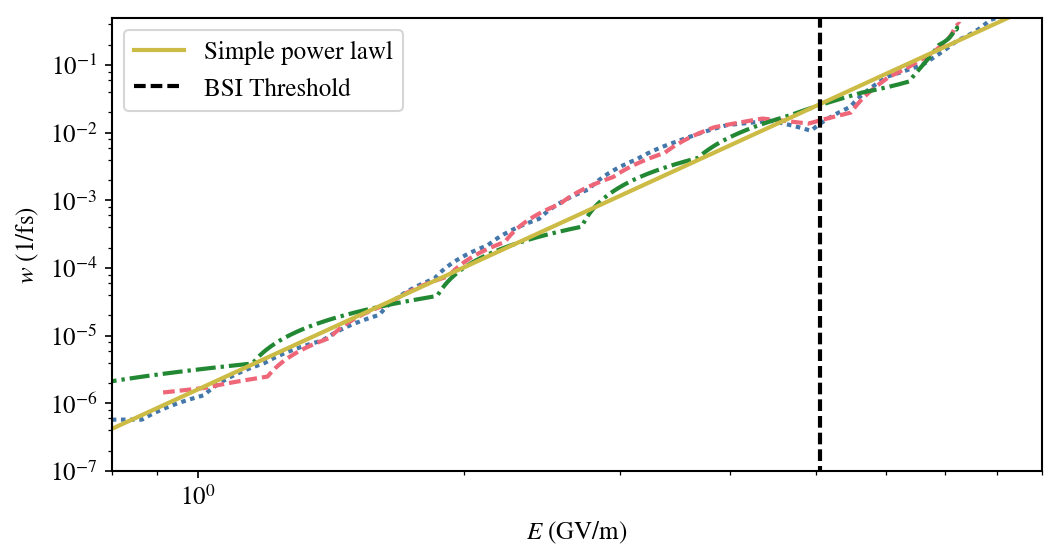

In [24]:
plt.figure(figsize=(8, 4), dpi=150)
sel = np.logical_and(p0_x0_z0 < 1.0, p0_x0_z0 > 0.1)
plt.plot(e_x0_z0_f(t_rate)[sel], w_x0_z0[sel], ':')
sel = np.logical_and(p0_x0_z50 < 1.0, p0_x0_z50 > 0.1)
plt.plot(e_x0_z50_f(t_rate)[sel], w_x0_z50[sel], '--')
sel = np.logical_and(p0_x78_z50 < 1.0, p0_x78_z50 > 0.1)
plt.plot(e_x78_z50_f(t_rate)[sel], w_x78_z50[sel], '-.')

plt.plot(E/1e9, f(E/1e9), label='Simple power lawl')
atom = ionization.Li
BSI = BSI_threshold(atom['EI'])
BSI = ionization.field_from_intensity(BSI*1e-14)
plt.plot([BSI, BSI], [0, 10], 'k--', label='BSI Threshold')
plt.legend()
plt.xlabel(r'$E$ (GV/m)')
plt.ylabel(r'$w$ (1/fs)')
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.8, 9)
plt.ylim(1e-7, 0.5)
plt.show()

BSI intensity 3.38E+12 W/cm^2
Keldysh at BSI 3.66


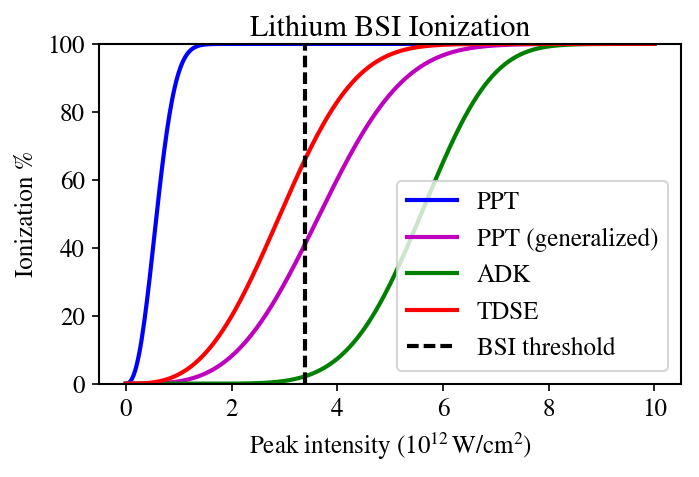

In [25]:
I = np.linspace(0, 10e-2, 400)
t = np.linspace(-250, 250, 1000)
tau = 70
atom = ionization.Li
IN = np.size(I)
env = np.zeros(IN)
for x in range(0, IN):
    Eenv = abs(ionization.gaussian_envelope(I[x], t, tau))
    rate = w_ppt(Eenv)
    env[x] = 1 - np.exp(-integrate.simps(rate, t))

plasma = env*100

for x in range(0, IN):
    Eenv = abs(ionization.gaussian_envelope(I[x], t, tau))
    rate = w_pptcc(Eenv)
    env[x] = 1 - np.exp(-integrate.simps(rate, t))

plasma2 = env*100

for x in range(0, IN):
    Eenv = abs(ionization.gaussian_envelope(I[x], t, tau))
    rate = a*Eenv**b
    env[x] = 1 - np.exp(-integrate.simps(rate, t))

plasma4 = env*100
BSI = BSI_threshold(atom['EI'])
print('BSI intensity %0.2E W/cm^2' % BSI)
print('Keldysh at BSI %0.2f' % ionization.keldysh(atom['EI'],BSI/1e14, 0.8))
plasma3 = ionization_plot(atom, I, t, tau, 1)*100

plt.figure(figsize=(5, 3), dpi=150)
plt.plot(I*100, plasma, 'b-')
plt.plot(I*100, plasma2, 'm-')
plt.plot(I*100, plasma3, 'g-')
plt.plot(I*100, plasma4, 'r-')
plt.plot([BSI*1e-12, BSI*1e-12], [0, 100], 'k--')
plt.ylabel('Ionization %')
plt.xlabel('Peak intensity ($10^{12}\,\mathrm{W/cm}^2$)')
plt.title('Lithium BSI Ionization')
plt.legend(['PPT', 'PPT (generalized)', 'ADK', 'TDSE', 'BSI threshold'])
plt.ylim(0, 100)
plt.show()